# Introduction to DESI SV Spectra

The goal of this notebook is to demonstrate how to read in and manipulate DESI SV spectra using on-sky data. Specifically, we will use the February/March 2020 mini-SV-2 runs taken as part of DESI _commissioning_.

If you identify any errors or have requests for additional functionality please create a new issue at https://github.com/desihub/tutorials/issues or send a note to desi-data@desi.lbl.gov.

Note that this tutorial specifically deals with on-sky data from SV (or, currently, mini-SV). To learn how to work with Main Survey data look at the _Introduction to DESI Spectra_ tutorial instead. (e.g. https://github.com/desihub/tutorials/blob/master/Intro_to_DESI_spectra.ipynb).

Last updated December 2020 using the 20.8 software release.

## Getting started

### Using NERSC

The easiest way to get started is to use the jupyter server at NERSC so that you don't need to
install any code or download any data locally.

If you need a NERSC account, see https://desi.lbl.gov/trac/wiki/Computing/AccessNersc

Then do the one-time jupyter configuration described at https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC

From a NERSC command line, checkout a copy of the tutorial code, *e.g.* from cori.nersc.gov
```console
mkdir -p $HOME/desi/
cd $HOME/desi/
git clone https://github.com/desihub/tutorials
```
And then go to https://jupyter.nersc.gov, login, navigate to where you checked out this package (*e.g.* `$HOME/desi/tutorials`), and double-click on `Intro_to_DESI_SV_spectra.ipynb`.

This tutorial has been tested using the "DESI 20.8" kernel installed at NERSC.  To get an equivalent environment from a cori command line:
```console
source /global/common/software/desi/desi_environment.sh 20.8
```

## Import required modules

In [1]:
import os
import numpy as np
import healpy as hp
from glob import glob
import fitsio
from collections import defaultdict

# ADM Note that we use the commissioning targeting mask, as we're working with mini-SV data from commissioning.
from desitarget.cmx.cmx_targetmask import cmx_mask  
import desispec.io

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


If you are running locally and any of these fail, 
you should go back through the [installation instructions](https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop) and/or email `desi-data@desi.lbl.gov` if you get stuck.
If you are running from jupyter.nersc.gov and have problems, double check that your kernel is "DESI 20.8".

## Environment variables and data

DESI uses environment variables to define the base directories for where to find data.  The below paths are for NERSC, but if you are running locally or want to access a different dataset, change these as needed to wherever your dataset is.

Spectro production runs are grouped under `$DESI_SPECTRO_REDUX`, with `$SPECPROD` indicating which run to use, such that the data are under `$DESI_SPECTRO_REDUX/$SPECPROD`.  *e.g.* during operations, official productions will be in `$DESI_SPECTRO_REDUX=/global/cfs/cdirs/desi/spectro/redux` and `$SPECPROD` would be the name for individual data assemblies, *e.g.* `$SPECPROD=DA1`.  In this case, we'll use `$SPECPROD=daily`, which corresponds to the daily reductions for mini-SV-2.

In [2]:
%set_env DESI_SPECTRO_REDUX=/global/cfs/cdirs/desi/spectro/redux
%set_env SPECPROD=daily

env: DESI_SPECTRO_REDUX=/global/cfs/cdirs/desi/spectro/redux
env: SPECPROD=daily


`desispec.io.specprod_root` can handle the environment variable path wrangling for you:

In [3]:
reduxdir = desispec.io.specprod_root()
print(reduxdir)

/global/cfs/cdirs/desi/spectro/redux/daily


In [4]:
#- Do check that these are set correctly before proceeding
def check_env():
    for env in ('DESI_SPECTRO_REDUX', 'SPECPROD'):
        if env in os.environ:
            print('${}={}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))

    reduxdir = desispec.io.specprod_root()
    if not os.path.exists(reduxdir):
        print("ERROR: {} doesn't exist; check $DESI_SPECTRO_REDUX/$SPECPROD".format(reduxdir))
    else:
        print('OK: {} exists'.format(reduxdir))

check_env()

$DESI_SPECTRO_REDUX=/global/cfs/cdirs/desi/spectro/redux
$SPECPROD=daily
OK: /global/cfs/cdirs/desi/spectro/redux/daily exists


## Data Model for the spectra

### Directory structure

Spectra from individual exposures are in the `exposures` directory.  But since SV will focus on targeting individual _tiles_, the relevant directory and file structure is: 

```
$DESI_SPECTRO_REDUX/$SPECPROD/tiles/$TILE/$DATE/*-$SPECTROGRAPH-$TILE-$DATE.fits
```

where:

* `$TILE` is the number of the relevant SV (or mini-SV) tile. For example, for mini-SV-2, see the list of tiles on the mini-SV-2 [wiki page](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2#Fieldcenters).
* `$DATE` is the date expressed as YYYYMMDD, for example 20200229 for year=2020, month=february, day=29.
* `$SPECTROGRAPH` corresponds to the DESI spectrograph used to observe the targets (0-9).

The files we will focus on for this tutorial correspond to `$TILE=70003` and `$DATE=20200226` and `$SPECTROGRAPH=0`. For example:

```
$DESI_SPECTRO_REDUX/$SPECPROD/tiles/70003/20200226/coadd-0-70003-20200226.fits
$DESI_SPECTRO_REDUX/$SPECPROD/tiles/70003/20200226/zbest-0-70003-20200226.fits
```
where the first file contains the (coadded) spectra and the second file contains information on the best-fit redshifts from the [redrock](https://github.com/desihub/redrock) code.

Let's poke around in these directories.

In [5]:
basedir = os.path.join(os.getenv("DESI_SPECTRO_REDUX"), os.getenv("SPECPROD"), "tiles")
subdir = sorted(os.listdir(basedir))
print(basedir)
print(subdir)

/global/cfs/cdirs/desi/spectro/redux/daily/tiles
['63075', '63159', '63160', '63161', '63162', '63163', '63164', '63165', '63166', '63167', '63168', '63169', '63170', '63171', '63211', '63224', '63225', '63226', '63227', '63228', '63229', '63230', '63231', '63232', '63233', '63234', '63235', '63236', '65008', '66000', '66003', '66014', '66019', '67142', '67230', '68000', '68001', '68002', '70002', '70003', '70004', '70005', '70006', '70500', '70502', '70506', '70508', '70510', '70511', '70512', '70513', 'temp']


In [6]:
basedir = os.path.join(basedir, subdir[0])
subdir = sorted(os.listdir(basedir))
print(basedir)
print(subdir)

/global/cfs/cdirs/desi/spectro/redux/daily/tiles/63075
['20200219', '20200220', '20200224', '20200225', '20200226', '20200229', '20200304']


In [7]:
basedir = os.path.join(basedir, subdir[2])
coaddfiles = glob(os.path.join(basedir, "*coadd*"))
zbestfiles = glob(os.path.join(basedir, "*zbest*"))
print(basedir)
print(coaddfiles)
print(zbestfiles)

/global/cfs/cdirs/desi/spectro/redux/daily/tiles/63075/20200224
['/global/cfs/cdirs/desi/spectro/redux/daily/tiles/63075/20200224/coadd-6-63075-20200224.fits', '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/63075/20200224/coadd-0-63075-20200224.fits', '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/63075/20200224/coadd-9-63075-20200224.fits', '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/63075/20200224/coadd-7-63075-20200224.fits', '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/63075/20200224/coadd-3-63075-20200224.fits']
['/global/cfs/cdirs/desi/spectro/redux/daily/tiles/63075/20200224/zbest-6-63075-20200224.fits', '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/63075/20200224/zbest-3-63075-20200224.fits', '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/63075/20200224/zbest-7-63075-20200224.fits', '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/63075/20200224/zbest-9-63075-20200224.fits', '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/63075/20200224/zbest-0-63075-

### spectra file format

What about the Data Model for the coadded spectra themselves?

In [8]:
tile, date, spectrograph = "70003", "20200226", "0"
dirname = os.path.join(os.getenv("DESI_SPECTRO_REDUX"), os.getenv("SPECPROD"), "tiles", tile, date)
filename = "coadd-{}-{}-{}.fits".format(spectrograph, tile, date)
specfilename = os.path.join(dirname, filename)
DM = fitsio.FITS(specfilename)
DM


  file: /global/cfs/cdirs/desi/spectro/redux/daily/tiles/70003/20200226/coadd-0-70003-20200226.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      FIBERMAP
  2      IMAGE_HDU       BRZ_WAVELENGTH
  3      IMAGE_HDU       BRZ_FLUX
  4      IMAGE_HDU       BRZ_IVAR
  5      IMAGE_HDU       BRZ_MASK
  6      IMAGE_HDU       BRZ_RESOLUTION

HDU 0 is blank.  The others should be used by name, not by number since the order could vary.

`FIBERMAP` stores the mapping of the imaging information used to target and place a fiber on the source.

The other HDUs contain the wavelength arrays, flux, inverse variance (ivar), mask (0 is good), and spectral resolution data coadded across each of the "B", "R", and "Z" cameras.

Let's start by looking at the fibermap.

In [9]:
fm = fitsio.read(specfilename, 'FIBERMAP')
fm.dtype.descr

[('TARGETID', '>i8'),
 ('PETAL_LOC', '>i2'),
 ('DEVICE_LOC', '>i4'),
 ('LOCATION', '>i4'),
 ('FIBER', '>i4'),
 ('FIBERSTATUS', '>i4'),
 ('TARGET_RA', '>f8'),
 ('TARGET_DEC', '>f8'),
 ('PMRA', '>f4'),
 ('PMDEC', '>f4'),
 ('PMRA_IVAR', '>f4'),
 ('PMDEC_IVAR', '>f4'),
 ('REF_EPOCH', '>f4'),
 ('LAMBDA_REF', '>f4'),
 ('FA_TARGET', '>i8'),
 ('FA_TYPE', '|u1'),
 ('OBJTYPE', '<U3'),
 ('FIBERASSIGN_X', '>f4'),
 ('FIBERASSIGN_Y', '>f4'),
 ('NUMTARGET', '>i2'),
 ('PRIORITY', '>i4'),
 ('SUBPRIORITY', '>f8'),
 ('OBSCONDITIONS', '>i4'),
 ('NUMOBS_MORE', '>i4'),
 ('RELEASE', '>i2'),
 ('BRICKID', '>i4'),
 ('BRICKNAME', '<U8'),
 ('BRICK_OBJID', '>i4'),
 ('MORPHTYPE', '<U4'),
 ('TARGET_RA_IVAR', '>f4'),
 ('TARGET_DEC_IVAR', '>f4'),
 ('EBV', '>f4'),
 ('FLUX_G', '>f4'),
 ('FLUX_R', '>f4'),
 ('FLUX_Z', '>f4'),
 ('FLUX_IVAR_G', '>f4'),
 ('FLUX_IVAR_R', '>f4'),
 ('FLUX_IVAR_Z', '>f4'),
 ('MW_TRANSMISSION_G', '>f4'),
 ('MW_TRANSMISSION_R', '>f4'),
 ('MW_TRANSMISSION_Z', '>f4'),
 ('FRACFLUX_G', '>f4'),
 ('FRAC

`TARGETID` is the unique mapping from target information to a fiber. So, if you wanted to look up full imaging information for a spectrum, you can map back to target files using `TARGETID`.

As we are only looking at a single spectrograph this should correspond to a single petal in the DESI focal plane. I wonder if that's true?

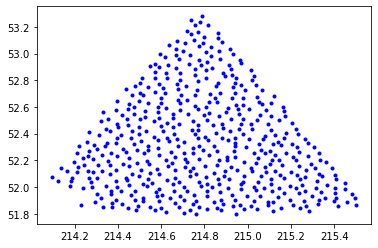

In [10]:
plt.plot(fm["TARGET_RA"],fm["TARGET_DEC"],'b.')

This certainly looks like one petal to me.  Let's repeat, color coding by spectrograph number.

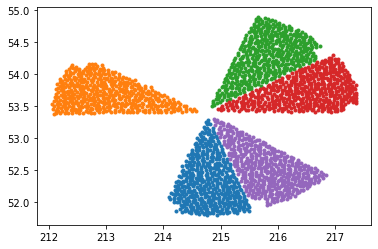

In [11]:
# ADM as of mini-SV-2 we only have spectrographs 0, 3, 6, 7, 9.
for spectrograph in "0", "3", "6", "7", "9":
    filename = "coadd-{}-{}-{}.fits".format(spectrograph, tile, date)
    specfilename = os.path.join(dirname, filename)
    DM = fitsio.FITS(specfilename)
    fm = fitsio.read(specfilename, 'FIBERMAP')
    plt.plot(fm["TARGET_RA"],fm["TARGET_DEC"], '.')

Note that in addition to having multiple tiles, we also have multiple exposures of the same tile resulting in multiple spectra of the same targets.

In [12]:
DM


  file: /global/cfs/cdirs/desi/spectro/redux/daily/tiles/70003/20200226/coadd-9-70003-20200226.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      FIBERMAP
  2      IMAGE_HDU       BRZ_WAVELENGTH
  3      IMAGE_HDU       BRZ_FLUX
  4      IMAGE_HDU       BRZ_IVAR
  5      IMAGE_HDU       BRZ_MASK
  6      IMAGE_HDU       BRZ_RESOLUTION

The remaining extensions store the wavelength, flux, inverse variance on the flux, mask and resolution matrix coadded for the B, R and Z arms of the spectrograph. Let's check that the full wavelength coverage across all 3 arms of each of the DESI spectrographs is the same:

In [13]:
for spectrograph in "9", "7", "6", "3", "0":
    filename = "coadd-{}-{}-{}.fits".format(spectrograph, tile, date)
    specfilename = os.path.join(dirname, filename)
    wave = fitsio.read(specfilename, 'BRZ_WAVELENGTH')
    print("wavelength coverage of spectrograph {}: {:.1f} to {:.1f} Angstroms".format(spectrograph, np.min(wave), np.max(wave)))

wavelength coverage of spectrograph 9: 3600.0 to 9824.0 Angstroms
wavelength coverage of spectrograph 7: 3600.0 to 9824.0 Angstroms
wavelength coverage of spectrograph 6: 3600.0 to 9824.0 Angstroms
wavelength coverage of spectrograph 3: 3600.0 to 9824.0 Angstroms
wavelength coverage of spectrograph 0: 3600.0 to 9824.0 Angstroms


## Reading in and Displaying spectra

Now that we understand the Data Model, let's plot some spectra. To start, let's use the file we've already been manipulating (for spectrograph 0) and read in the flux to go with the wavelengths we already have.

In [14]:
flux = fitsio.read(specfilename,'BRZ_FLUX')

Note that the wavelength arrays are 1-D (every spectrum in the spectral file is mapped to the same binning in wavelength) but the flux array (and flux_ivar, mask etc. arrays) are 2-D, because they contain multiple spectra:

In [15]:
print(wave.shape)
print(flux.shape)

(7781,)
(500, 7781)


Let's plot one of the spectra from this file:

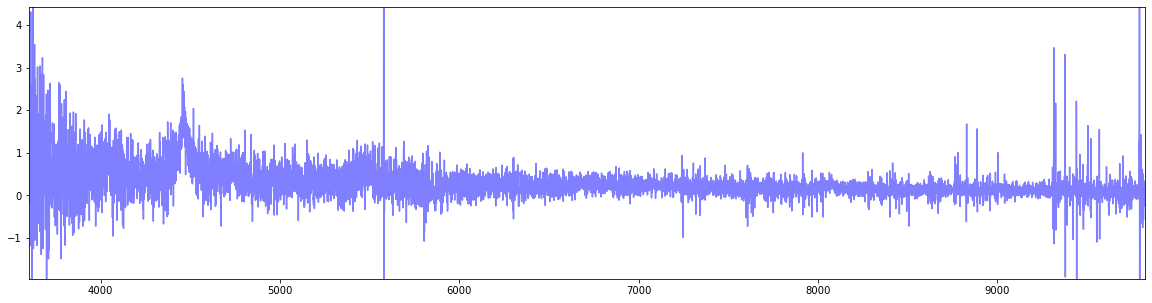

In [16]:
spectrum = 23
# ADM make the figure 20-by-5 in size.
plt.figure(figsize=(20, 5))
# ADM some reasonable plot limits.
xmin, xmax, ymin, ymax = np.min(wave), np.max(wave), np.min(flux[spectrum][0:100]), np.max(flux[spectrum][0:100])
plt.axis([xmin, xmax, ymin, ymax])
plt.plot(wave, flux[spectrum], 'b-', alpha=0.5)

## A DESI-specific spectrum reader

Note that, for illustrative purposes, we discussed the Data Model in detail and read in the required files individually from that Data Model. But, the DESI data team has also developed standalone functions in `desispec.io` to facilitate reading in the plethora of information in the spectral files. For example:

In [17]:
specobj = desispec.io.read_spectra(specfilename)

The wavelengths and flux in each band are then available as dictionaries in the `wave` and `flux` attributes:

In [18]:
specobj.wave

{'brz': array([3600. , 3600.8, 3601.6, ..., 9822.4, 9823.2, 9824. ])}

In [19]:
specobj.flux

{'brz': array([[ 1.03085494e+00,  5.34286082e-01, -9.64657187e-01, ...,
         -3.80556762e-01, -2.18447313e-01, -8.33308101e-02],
        [-2.55843133e-01, -8.46773267e-01, -1.68721449e+00, ...,
          4.10736144e-01,  1.08134806e-01, -4.81233299e-02],
        [ 5.07653379e+00,  6.74898148e+00,  4.82973862e+00, ...,
          1.69361949e+00,  1.59529316e+00,  1.25684929e+00],
        ...,
        [ 1.06593895e+00, -8.84459436e-01,  3.35761309e-01, ...,
          1.08722314e-01,  2.57558078e-02, -3.28279063e-02],
        [ 1.64347768e+00, -1.54139948e+00, -1.17252338e+00, ...,
         -3.61708133e-03,  1.42026439e-01,  1.00789659e-01],
        [ 6.03420258e-01,  2.17040747e-01, -2.72437215e+00, ...,
         -3.16569030e-01, -2.02280059e-02, -5.89266233e-03]])}

So, to plot the (zeroth-indexed) 24th spectrum:

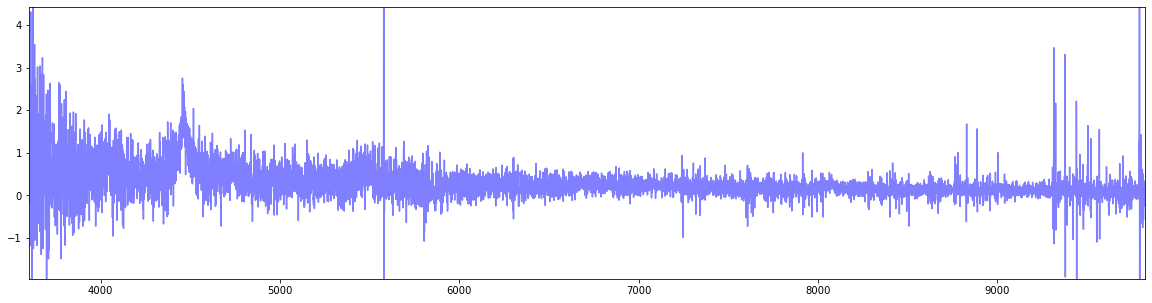

In [20]:
spectrum = 23
plt.figure(figsize=(20, 5))
plt.axis([xmin, xmax, ymin, ymax])
plt.plot(specobj.wave["brz"], specobj.flux["brz"][spectrum], 'b-', alpha=0.5)

which should look very similar to one of the first plots we made earlier in the tutorial. 

The fibermap information is available as a table in the `fibermap` attribute:

In [21]:
specobj.fibermap

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PHOTSYS,CMX_TARGET,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,MEAN_DELTA_X,MEAN_DELTA_Y,FIBER_RA,FIBER_DEC,RMS_DELTA_X,RMS_DELTA_Y,FIRST_FIBER,LAST_FIBER,NUM_FIBER
int64,int16,int32,int32,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int16,int32,float64,int32,int32,int16,int32,bytes8,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,bytes1,int64,int64,int64,int64,float32,float32,float32,float32,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64
35191248222423832,0,523,523,368,512,214.44605767832988,51.84406836443377,0.0,0.0,0.0,0.0,0.0,5400.0,9007199254742016,1,TGT,46.74537,-394.10425,0,4000,0.21990202658387958,65535,99,8001,590822,2144p517,2840,PSF,51333153000.0,54979980000.0,0.009342048,0.07065777,0.5183535,3.890564,436.4544,228.05014,95.41433,0.9727245,0.981544,0.9896342,4.790217e-07,4.101142e-08,-3.1664158e-07,0.0064982125,0.0010419904,0.0,0.9999985,0.99999803,1.0000007,3,4,3,585.86066,309.23462,109.99242,422.08148,194.14775,59.241077,631.47375,552.9918,174.71582,-227.9145,6.346824,1.1792632,0.0020697613,2.4200346e-05,0.99841803,0.9990282,0.99979264,0.9999217,0,0,0,0.055031408,0.40371677,3.0301442,0.055031408,0.40371677,3.0301442,163,163,2818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,True,0.0,0.0,N,9007199254742016,3410,2,11424,0.0,0.0,0.0,0.0,0,0,0,3,47.367,-396.32,-0.6622857142857143,2.601142857142857,0.0,0.0,0.662518786795622,2.601146780062319,368,368,1
35191248222423864,0,522,522,478,0,214.4849311311757,51.82944600322742,0.0,0.0,0.0,0.0,0.0,5400.0,1024,1,TGT,40.692936,-398.06967,0,500,0.8262228440133043,65535,99,8001,590822,2144p517,2872,PSF,81617840000.0,86225625000.0,0.008901713,0.49187332,1.5277255,3.5018857,

In [22]:
specobj.target_ids()

35191248222423832
35191248222423864
35191248222424145
35191248222424151
35191248222424269
35191248222424420
35191248222424545
35191248222424614
35191248222424683
35191248226617964
35191248226617968


There are also functions for getting the number of spectra and selecting a subset of spectra.  All of the information that could be read in from the different extensions of the spectral file can be retrieved from the `specobj` object. Here's what's available:

In [23]:
dir(specobj)

['R',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bands',
 '_ftype',
 '_single',
 'bands',
 'extra',
 'fibermap',
 'flux',
 'ftype',
 'ivar',
 'mask',
 'meta',
 'num_spectra',
 'num_targets',
 'resolution_data',
 'scores',
 'select',
 'target_ids',
 'update',
 'wave',
 'wavelength_grid']

## Target classes

What about if we only want to plot spectra of certain target classes? For mini-SV-2 (which is part of DESI _commissioning_) the targeting information is stored in the `CMX_TARGET` entries of the fibermap array:

In [24]:
specobj.fibermap["CMX_TARGET"].info

name = CMX_TARGET
dtype = int64
class = Column
n_bad = 0
length = 500

and which target corresponds to which targeting bit is stored in the commisioning (cmx) mask (we imported this near the beginning of the notebook).

In [25]:
cmx_mask

cmx_mask:
  - [STD_GAIA,         0, "Gaia stars used for dithering (and other) tests", {'obsconditions': 'DARK|GRAY|BRIGHT', 'priorities': {'UNOBS': 2400, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 2400, 'MORE_ZGOOD': 2400}, 'numobs': 100}]
  - [SV0_STD_FAINT,    1, "SV-like STD_FAINT class is set (very early SV selection)", {'obsconditions': 'DARK|GRAY', 'priorities': {'UNOBS': 2600, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 2600, 'MORE_ZGOOD': 2600}, 'numobs': 100}]
  - [SV0_STD_BRIGHT,   2, "SV-like STD_BRIGHT class is set (very early SV selection)", {'obsconditions': 'BRIGHT|POOR|TWILIGHT12|TWILIGHT18', 'priorities': {'UNOBS': 2600, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 2600, 'MORE_ZGOOD': 2600}, 'numobs': 100}]
  - [STD_TEST,         3, "Very bright stars for early tests", {'obsconditions': 'DARK|GRAY|BRIGHT', 'priorities': {'UNOBS': 2800, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 2800, 'MORE_ZGOOD': 2800}, 'numobs': 1}]
  - [STD_

Let's find the indexes of all standard stars in the spectral file:

In [26]:
stds = np.where(specobj.fibermap["CMX_TARGET"] & cmx_mask.mask("STD_FAINT|STD_BRIGHT|SV0_STD_FAINT|SV0_STD_BRIGHT"))[0]
print(stds)

[  2  12  44  98 134 145 171 177 180 181 194 205 207 264 265 321 333 338
 343 360 368]


Where were these located on the original plate-fiber mapping?

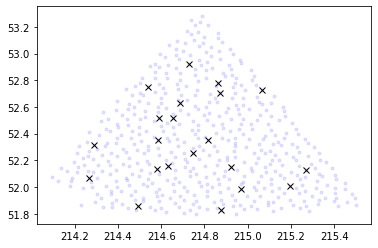

In [27]:
fm = specobj.fibermap   #- shorthand
plt.plot(fm["TARGET_RA"],fm["TARGET_DEC"],'b.', alpha=0.1)
plt.plot(fm["TARGET_RA"][stds],fm["TARGET_DEC"][stds],'kx')

Let's take a look at the spectra of the first 9 of these standard stars.

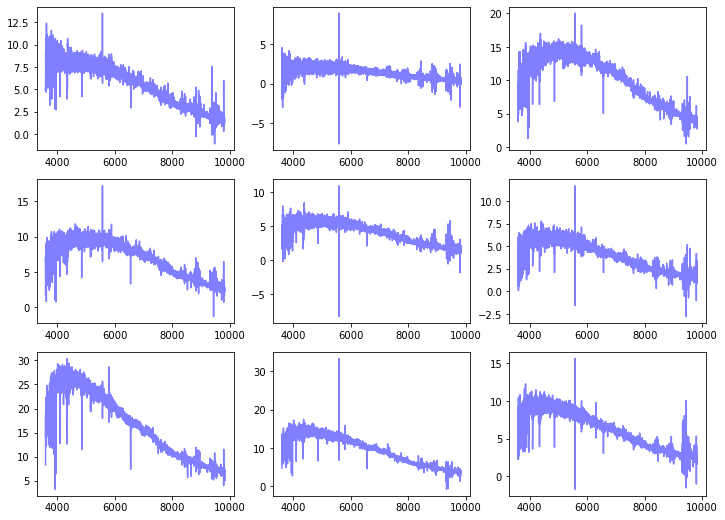

In [28]:
print()
figure(figsize=(12, 9))
for panel, std in enumerate(stds[:9]):
    subplot(3, 3, panel+1)
    plt.plot(specobj.wave['brz'], specobj.flux["brz"][std], 'b-', alpha=0.5)

These seem star-like. Let's zoom in on some of the Balmer series for the zeroth standard:

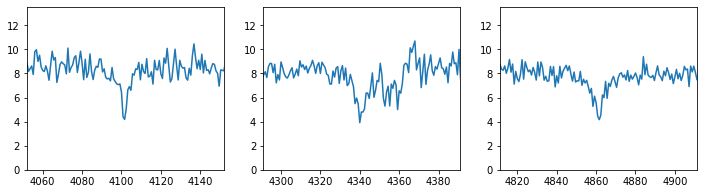

In [29]:
Balmer = [4102, 4341, 4861]
halfwindow = 50
figure(figsize=(4*len(Balmer), 3))
for i in range(len(Balmer)):
    subplot(1, len(Balmer), i+1)
    plt.axis([Balmer[i]-halfwindow, Balmer[i]+halfwindow, 0, np.max(flux[stds[0]])])
    plt.plot(wave, flux[stds[0]])
    # plt.show()

## Redshifts

The directory from which we took these spectra also contains information on the best-fit redshifts for the spectra from the [redrock](https://github.com/desihub/redrock) code.

In [30]:
zfilename = specfilename.replace('coadd', 'zbest')
zs = fitsio.read(zfilename)
zs.dtype.descr

[('TARGETID', '>i8'),
 ('CHI2', '>f8'),
 ('COEFF', '>f8', (10,)),
 ('Z', '>f8'),
 ('ZERR', '>f8'),
 ('ZWARN', '>i8'),
 ('NPIXELS', '>i8'),
 ('SPECTYPE', '<U6'),
 ('SUBTYPE', '<U20'),
 ('NCOEFF', '>i8'),
 ('DELTACHI2', '>f8'),
 ('NUMEXP', '>i4'),
 ('NUMTILE', '>i4')]

As a sanity check, let's ensure that there are the same number of redshifts, targets, and spectra in the files. This may not be so in the DESI _Main Survey_, where there might be repeat observations.

In [31]:
print(zs.shape[0], 'redshifts')
print(specobj.num_targets(), 'targets')
print(specobj.num_spectra(), 'spectra')
print(specobj.flux['brz'].shape, 'shape of flux["brz"]')

500 redshifts
500 targets
500 spectra
(500, 7781) shape of flux["brz"]


Seems logical: 5000 DESI fibers, 10 petals, so 500 entries per petal.

The `TARGETID` (which is intended to be unique for each source) is useful for mapping source spectra to redshift. Let's extract all sources that were targeted as SV-like quasars in mini-SV-2 (the bit-name `SV0_QSO`; not to be confused with the Main-Survey-like quasars that were targeted as `MINI_SV_QSO`) using the fibermap information from the spectral file, and plot the first 20.

132 QSOs


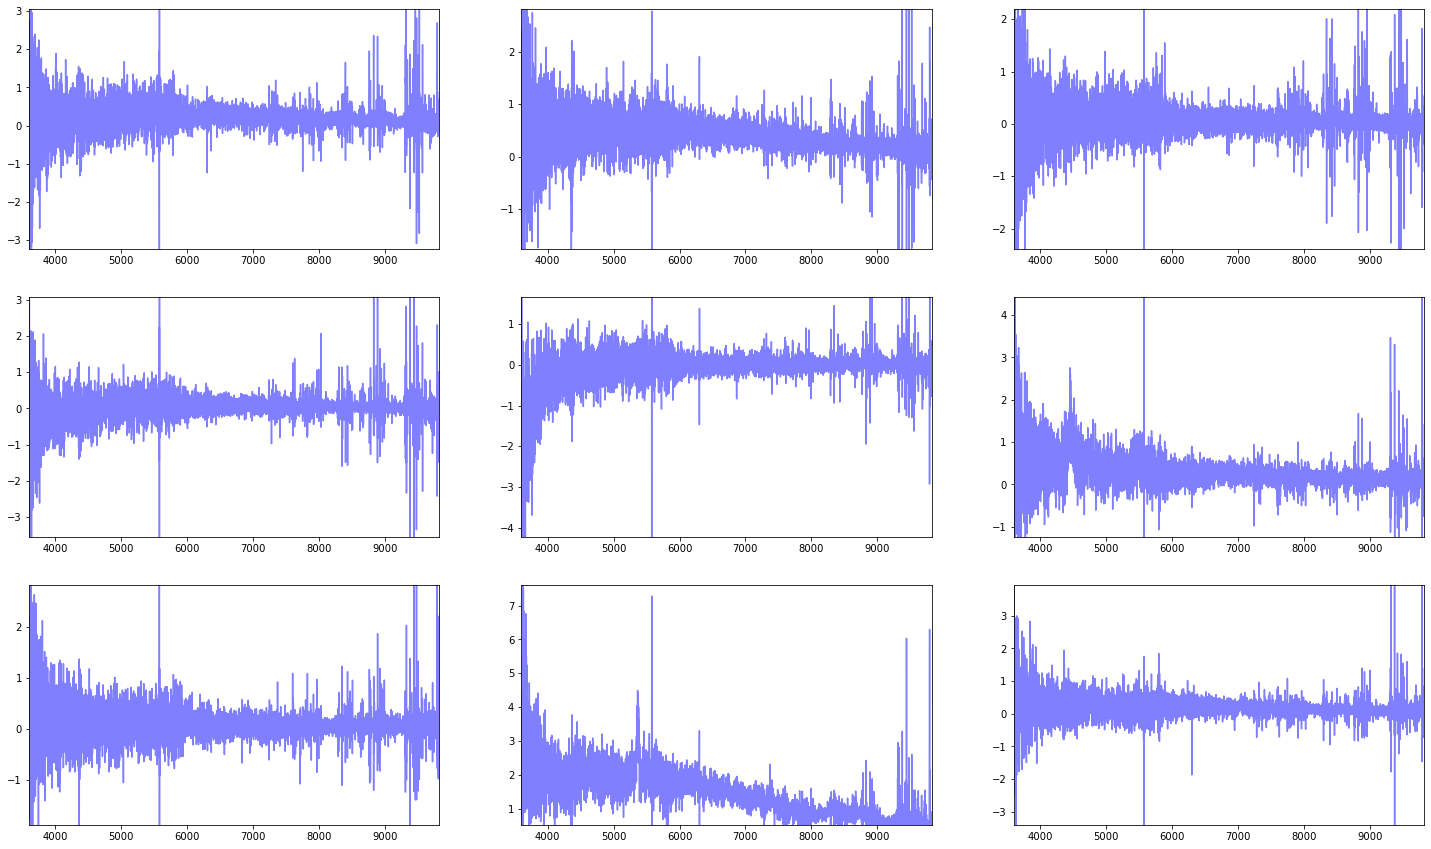

In [32]:
qsos = np.where(specobj.fibermap["CMX_TARGET"] & cmx_mask["SV0_QSO"])[0]
print(len(qsos), 'QSOs')
plt.figure(figsize=(25,15))
xmin, xmax = np.min(wave), np.max(wave)
for i in range(len(qsos))[0:9]:
    plt.subplot(3,3,i+1)
    ymin, ymax = np.min(flux[qsos[i]][30:50]), np.max(flux[qsos[i]][0:50])
    plt.axis([xmin, xmax, ymin, ymax])
    plt.plot(wave, flux[qsos[i]],'b', alpha=0.5)
    # plt.show()

I definitely see some broad emission lines! Let's match these quasar targets to the redshift file on `TARGETID` to extract their best-fit redshifts from `redrock`:

In [33]:
dd = defaultdict(list)
for index, item in enumerate(zs["TARGETID"]):
    dd[item].append(index)
zqsos = [index for item in fm[qsos]["TARGETID"] for index in dd[item] if item in dd]

That might be hard to follow at first glance, but all I did was use some "standard" python syntax to match the indices in `zs` (the ordering of objects in the `redrock` redshift file) to those for quasars in `fm` (the ordering of quasars in the fibermap file), on the unique `TARGETID`, such that the indices stored in `qsos` for `fm` point to the corresponding indices in `zqsos` for `zs`. This might help illustrate the result:

In [34]:
zs[zqsos]["TARGETID"][0:7], np.array(fm[qsos]["TARGETID"][0:7])

(array([35191248222424269, 35191248222424683, 35191248226618337,
        35191248226618473, 35191248226618954, 35191248230812543,
        35191248230812879]),
 array([35191248222424269, 35191248222424683, 35191248226618337,
        35191248226618473, 35191248226618954, 35191248230812543,
        35191248230812879]))

Let's see what best-fit template `redrock` assigned to each quasar target. This information is stored in the `SPECTYPE` column.

In [35]:
zs[zqsos]["SPECTYPE"]

array(['GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'STAR', 'QSO', 'QSO',
       'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY',
       'QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY',
       'GALAXY', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'QSO', 'GALAXY',
       'STAR', 'QSO', 'QSO', 'GALAXY', 'QSO', 'GALAXY', 'QSO', 'QSO',
       'GALAXY', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY',
       'QSO', 'GALAXY', 'STAR', 'GALAXY', 'GALAXY', 'QSO', 'QSO',
       'GALAXY', 'GALAXY', 'QSO', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY',
       'GALAXY', 'GALAXY', 'QSO', 'QSO', 'QSO', 'GALAXY', 'QSO', 'GALAXY',
       'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY',
       'GALAXY', 'GALAXY', 'QSO', 'QSO', 'QSO', 'GALAXY', 'QSO', 'QSO',
       'QSO', 'QSO', 'GALAXY', 'QSO', 'GALAXY', 'QSO', 'QSO', 'QSO',
       'GALAXY', 'GALAXY', 'QSO', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY',
       'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY',

Or for standard stars:

In [36]:
dd = defaultdict(list)
for index, item in enumerate(zs["TARGETID"]):
    dd[item].append(index)
zstds = [index for item in fm[stds]["TARGETID"] for index in dd[item] if item in dd]

For stars, we can also display the type of star that `redrock` fit (this is stored in the `SUBTYPE` column):

In [37]:
zipper = zip(zs[zstds]["SUBTYPE"][10:15], zs[zstds]["SPECTYPE"][10:15])
for sub, spec in zipper:
    print("{}-{}".format(sub,spec))

K-STAR
K-STAR
A-STAR
F-STAR
F-STAR


Here, I just picked 5 correctly identified stars as an example. Note that the conversion to `utf-8` is simply for display purposes because the strings in `SUBTYPE` and `SPECTYPE` are stored as bytes instead of unicode.

OK, back to our quasars. Let's plot the quasar targets that *are identified as quasars* , but add a label for the `SPECTYPE` and the redshift fit by `redrock`. I'll also add some median filtering and over-plot some (approximate) typical quasar emission lines at the redrock redshift (if those lines would fall in the DESI wavelength coverage):

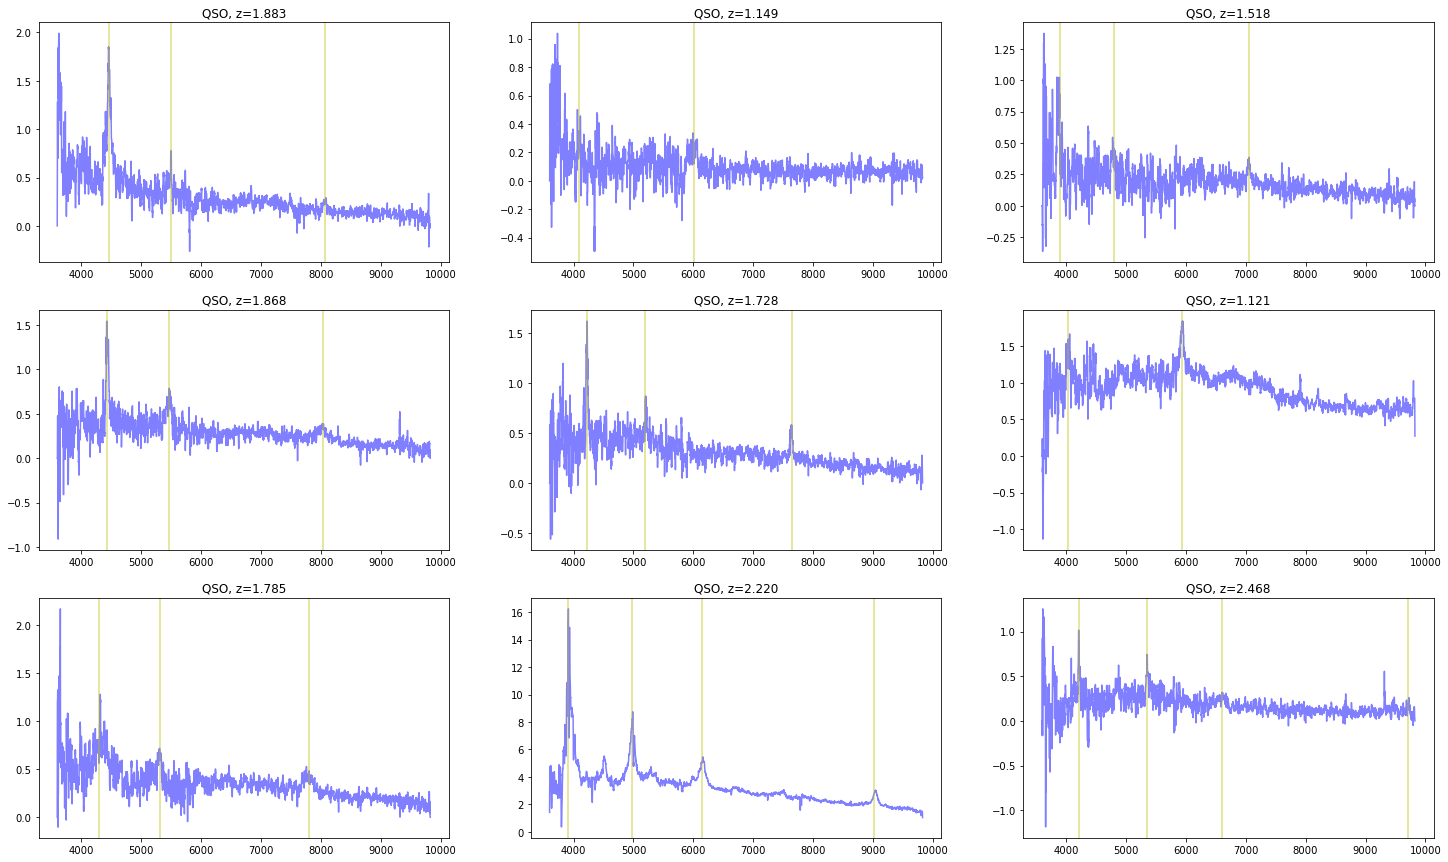

In [38]:
from scipy.signal import medfilt

# ADM we'll clip to z < 5, as redrock can misidentify low S/N sources as very-high-z quasars.
qsoid = np.where( (zs[zqsos]["SPECTYPE"] == 'QSO') & (zs[zqsos]["Z"] < 5) )[0]
qsolines = np.array([1216, 1546, 1906, 2800, 4853, 4960, 5008])

wave = specobj.wave["brz"]
flux = specobj.flux["brz"]
plt.figure(figsize=(25, 15))
for i in range(9):
    plt.subplot(3,3,1+i)
    spectype = zs[zqsos[qsoid[i]]]["SPECTYPE"]
    z = zs[zqsos[qsoid[i]]]["Z"]
    plt.plot(wave, medfilt(flux[qsos[qsoid[i]]], 15), 'b', alpha=0.5)
    plt.title("{}, z={:.3f}".format(spectype,z))
    for line in qsolines:
        if ((1+z)*line > np.min(wave)) & ((1+z)*line < np.max(wave)):
            axvline((1+z)*line, color='y', alpha=0.5)

## Appendix: code versions used

In [39]:
from desitutorials import print_code_versions as pcv
print("This tutorial last ran successfully to completion using the following versions of the following modules:") 
pcv()

This tutorial last ran successfully to completion using the following versions of the following modules:
python      : 3.8.3
numpy       : 1.19.1
scipy       : 1.5.0
astropy     : 4.0.1.post1
yaml        : 5.3.1
matplotlib  : 3.2.1
fitsio      : 1.1.2
healpy      : 1.14.0
desiutil    : 3.0.3
desispec    : 0.34.7
desitarget  : 0.42.0
speclite    : 0.9
